# COMP3359 Project
## Group 28: Classification of Tropical Cyclone Satellite Image by Intensity

---

### Introduction
In this project, we intend to develop a CNN-based model that accepts a satellite image of a tropical cyclone as input and
predicts a label the appropriate Dvorak T-number (a measure of tropical cyclone intensity) for it.
The T-number is derived using a manual method known as the Dvorak Technique (Dvorak,
1975; Dvorak, 1984) and we intend to let an AI model perform it without knowing the exact rules
and features to look for.

The dataset used is obtained from the website “Digital Typhoon”, a platform that
provides historical data (including satellite images) of tropical cyclones, provided by Prof. A. Kitamoto of
National Institute of Informatics (Japan), to whom we are highly indebted for his kind permission to use his data.

This notebook will be the implementation of our methodology, which is essentially a CNN multi-class image classifier.

References used:
- Dvorak, V.F. (1975, 5) Tropical Cyclone Intensity Analysis and Forecasting From
Satellite Imagery. Monthly Weather Review , Volume 3, pp.420-430.
- Dvorak, V.F. (1984) Tropical Cyclone Intensity Analysis Using Satellite Data. National
Oceanic and Atmospheric Administration. Washington D.C.: National Oceanic and
Atmospheric Administration.

### Introduction [New!]
In this project, we intend to develop a CNN-based model that accepts a satellite image of a tropical cyclone (TC) as input and
predicts a label, an intensity class, for it. We intend to let an AI model perform it without knowing the exact rules
and features to look for. There are six classes, namely class 0, class 1, class 2 a tropical depression, class 3 tropical storm, class 4 severe tropical storm and class 5 typhoon/hurricane (depending on in which part of the world do you live).

The dataset used is obtained from the National Institute of Informatics (Japan), provided by Prof. A. Kitamoto of
to whom we are highly indebted for his kind permission to use his data.

This notebook will be the implementation of our methodology, which is essentially a CNN multi-class image classifier.

### Table of Content
update needed

---
- Preperation and Prerequisites
- Data Exploration and Preprocesssing
- [Interim Prototype] Building and Training a Model - Take 1: Pre-trained Net
- [Interim Prototype] Building and Training a Model - Take 2: Custom CNN
- [Interim Prototype] Conclusions about the two models



### Preperation and Prerequesites

> This notebook designs to run un HKU GPU Farm, running it in colab will not work.

#### About data format
The raw data obtained (details below) were transformed into HDF5 format. This is due to the limited disk size in both colab and HKU gpu farm, which made us unable to load all pickle files (the original format) to VM's disk. Accessing them from google drive also super slow and unstable. Therefore, we merge them into once single HDF5 file with compression, which is 20% of orginial size. Also, HDF5 supports concurrent read which further speed up loading speed. The image data was originally float32, but we compressed it to uint8, which is also due to the disk limitation and we also found there is no big different in terms of quality.

In [ ]:
""" Install correct pytorch version """
# Uncomment % ... to see your CUDA version
# !/usr/local/cuda/bin/nvcc --version

# If you are using CUDA 10.0 (HKU GPU Phrase 1)
# !pip install Pillow==6.1
# !pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html

# If you have CUDA 10.1
# !pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# If you have CUDA 10.2
# !pip install pytorch torchvision

In [ ]:
""" Python packages you might need """
# !pip install h5py opencv-python
# !pip install efficientnet-pytorch

In [13]:
""" Import packages """
import os
import sys
import numpy as np
import pandas as pd
import glob
import h5py
import torch

In [14]:
""" Set path to data: """
# We dumped everything at root, so yeah.
dataset_dir = '.'
sys.path.append(dataset_dir)
IMAGES_H5 = f'{dataset_dir}/compressed_images.hdf5'
NPY_FOLDER = f'{dataset_dir}/uint'

In [15]:
# Know more about your machine
print(torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU")
print(os.cpu_count())

GeForce GTX 1080 Ti
8


In [16]:
# Load attribute of images from csv
LABELS = pd.read_csv(f"{dataset_dir}/labels_with_images.csv")
len(LABELS)

163665

In [17]:
# Alternatively you can load a particular image directly from disk (Slow)
# Helper function to get a image array from HDF5 file
def getImageFromH5(h5, row):
        img_name = f"{row['sequence']}{row['raw_index']}"
        return h5[img_name][()]

In [ ]:
# Alternative 2: Load it in from npy format(Faster in theory)
def getImageFromNPY(row):
    img_name = f"{row['sequence']}{row['raw_index']}"
    return np.load(f"{NPY_FOLDER}/{img_name}.npy")

In [18]:
""" Global variables """
learning_rate = 0.01 # will decay
n_epochs = 20
batch_size = 128 #or 512
print_freq = 500
RAND_SEED = 20200506
import random
random.seed(RAND_SEED)
torch.manual_seed(RAND_SEED)

## Data Exploration and Preprocessing

As mentioned in the proposal, we would use the dataset by Prof. A. Kitamoto of the National Institute of Informatics (NII). Via his website “Digital Typhoon”, a platform that provides historical data (including satellite images) of tropical cyclones, we have successfully obtained his research dataset for the use of this project. On Thursday 23 April, the magical day finally came, as we first laid hands on the dataset.

The dataset we obtained is immense. Compressed, the dataset is 43GB in size, which includes utility and sample code for our use, alongside with the main dish: **164541** images from 1978 to 2019, initially organized as pickles files (grouped by year), with the following columns:

* date and time when the image was taken
* class: intensity class as categroized by NII
* latitude and longitude of the TC in the image
* pressure (hectopascals/hPa): raw information of the TC's intensity
* interpolated: whether all data above were calculated by interpolation
* image: a multi-dimensional array that contains the image data. Each pixel on the image encodes temperature (in Kelvin).

Some of these fields are usused and would be dropped in due course.

We preprocessed the data by dropping rows with N/A values, transforming the images into HDF5 format and the other pickle data into a CSV. Thereby we can process the data easier. The following code reads the data and produces some plot about the distribution of the data. Similar procedures have been done for the interim model.

### Exploring the data 


In [19]:
# Lets go with import as usual
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
# Append few extra column of data for later use
LABELS = LABELS[['sequence','raw_index','datetime', 'class', 'latitude', 'longitude','pressure', 'TCxETC']]
LABELS['year'] = pd.to_datetime(LABELS['datetime'], format='%Y-%m-%d %X').dt.year
LABELS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163665 entries, 0 to 163664
Data columns (total 9 columns):
sequence     163665 non-null int64
raw_index    163665 non-null int64
datetime     163665 non-null object
class        163665 non-null int64
latitude     163665 non-null float64
longitude    163665 non-null float64
pressure     163665 non-null float64
TCxETC       163665 non-null int64
year         163665 non-null int64
dtypes: float64(3), int64(5), object(1)
memory usage: 11.2+ MB


Sample data:


<Figure size 720x720 with 0 Axes>

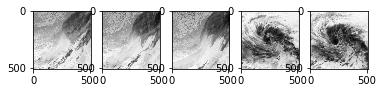

In [21]:
# Let's look at some sample images
plt.figure(figsize=(10,10))
print("Sample data:")
fig, ax = plt.subplots(1,5)
with h5py.File(IMAGES_H5, 'r') as h5:
    for i in range(5):
      img = getImageFromH5(h5, LABELS.loc[i])
      ax[i].imshow(img, cmap='gray')
plt.show()

In [ ]:
# If you using npy folder instead of hdf5 
plt.figure(figsize=(10,10))
print("Sample data:")
fig, ax = plt.subplots(1,5)
for i in range(5):
    img = getImageFromNPY(LABELS.loc[i])
    ax[i].imshow(img, cmap='gray')
plt.show()

In [22]:
sequence = LABELS['sequence'].values
raw_index = LABELS['raw_index'].values

In [ ]:
# Demonstrating the efficiency of loading things
%%timeit
for i in range(5):
    img = getImageFromNPY(LABELS.iloc[i])

In [ ]:
%%timeit
for i in range(5):
    img = np.load(f"{NPY_FOLDER}/{sequence[i]}{raw_index[i]}.npy")

In [23]:
%%timeit
with h5py.File(IMAGES_H5, 'r') as h5:
    for i in range(5):
        img = getImageFromH5(h5, LABELS.loc[i])

92.4 ms ± 4.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
# Labels of each row
list(LABELS.columns.values)

['sequence',
 'raw_index',
 'datetime',
 'class',
 'latitude',
 'longitude',
 'pressure',
 'TCxETC',
 'year']

Classes: [0 1 2 3 4 5]
Distribution 
0    42312
3    40694
1    36358
2    25703
4    18447
5      151
Name: class, dtype: int64


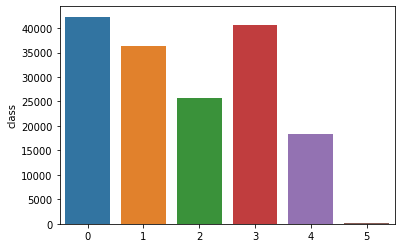

In [25]:
# Class
classes = np.sort(LABELS['class'].unique())
print("Classes:", classes)
print("Distribution ")
dist = LABELS['class'].value_counts()
print(dist)
sns.barplot(dist.index, dist)

In [60]:
# Code studies the relationship between classes and pressure value
pressure = LABELS['pressure']
for x in range(6):
    range_min = 2000.0
    range_max = 0.0
    for _, row in LABELS.iterrows():
        if row['class'] == x:
            if row['pressure'] > range_max:
                range_max = row['pressure']
            elif row['pressure'] < range_min:
                range_min = row['pressure']
    print("Class",x,"pressure range =", range_min, range_max)

Class 0 pressure range = 982.0 1018.0
Class 1 pressure range = 969.5 1011.333333
Class 2 pressure range = 951.666667 1005.0
Class 3 pressure range = 870.0 995.0
Class 4 pressure range = 940.0 1018.0
Class 5 pressure range = 925.0 1018.0


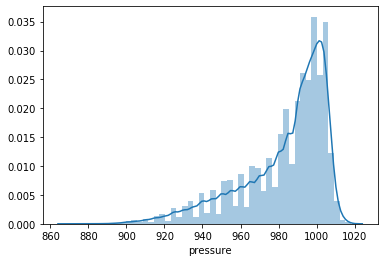

In [26]:
# Pressure distribution
pressure = LABELS['pressure']
sns.distplot(pressure)

In [27]:
# Pressure decile
decile = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
cutoff = pressure.quantile(decile)
print("Median of each quantile")
print(cutoff)
qcutted = pd.qcut(pressure, 10, labels=False)
print("Number of image in each bin")
qcutted.value_counts().sort_index()

Median of each quantile
0.1     950.000000
0.2     965.000000
0.3     977.000000
0.4     985.000000
0.5     990.666667
0.6     995.000000
0.7     998.000000
0.8    1002.000000
0.9    1004.000000
Name: pressure, dtype: float64
Number of image in each bin


0    18833
1    14951
2    15325
3    19252
4    13710
5    16662
6    16263
7    20964
8    12134
9    15571
Name: pressure, dtype: int64

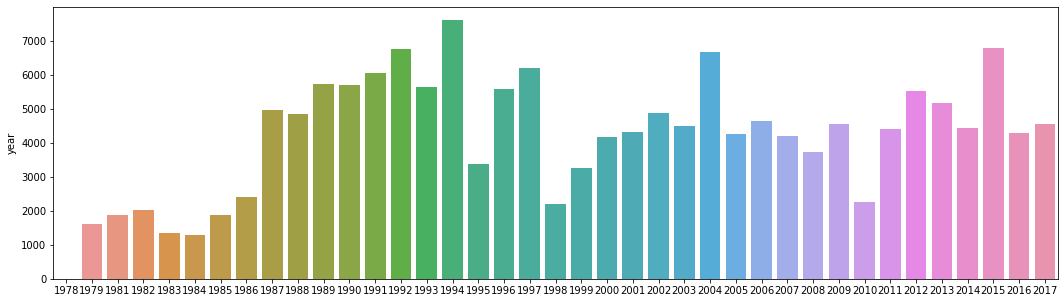

In [28]:
# By Year
years = LABELS['year']
count_years = years.value_counts()
plt.figure(figsize=(18,5))
sns.barplot(count_years.index, count_years)

#### Observations
There are some observations we made about the dataset.

* There is a general lack of images of stronger TCs.
  * Based on the given classes (0-5), we can observe that the classes 4 and 5 have much fewer samples than other classes.
  * It is beyond doubt that this is because stronger TCs do not happen as frequently.
  * We would bear with it for now and observe what is going to happen.
  * Potential solutions are:
    * rotate some images to make up for the numbers, but the images would be similar
    * check other sources for images, but the images would have different dimensions/zooming levels or may require other preprocessing

### Preprocessing

This part is rather straightforward. 

> Based on the criteria stated above, we drop unnecessary columns and bin the pressure values into labels (just using numbers 1-12 should be ok). 

Firstly, we selected the label attributes of interest. Here we try to predict the class (as given) instead of T-number first. Next the dataset is separated into train, dev and test sets. After that each set gets its own PyTorch DataLoader pipeline by the time we start training (the code is at the bottom), this step is reserved for later because pre-trained and custom models have different pre-processing requirements. We also random resize cropped the images (to introduce randomness and cull overfitting) and normalized the images.

In [29]:
# Import 
from sklearn.model_selection import train_test_split

In [30]:
# Pick useful label attributes only
processed_labels = LABELS[['class','sequence','raw_index','year']]

In [31]:
""" Group data into Train, Dev, Test set """
# To prevent Data leak, we seperate test data by year
def prepare_dataset(labels, ratio, year):
    processed_labels = labels[['class', 'sequence', 'raw_index', 'year']]
    test_set = processed_labels[processed_labels['year'] >= year]
    traindev_set = processed_labels[processed_labels['year'] < year]
    train_set, dev_set = train_test_split(
        traindev_set, train_size=ratio)
    print("[Test Size {}] [Train Size {}] [Dev Size {}]".format(len(test_set),len(train_set),len(dev_set)))
    return {'train': train_set, 'dev': dev_set, 'test': test_set}

_ = prepare_dataset(LABELS, 0.8, 2012)

[Test Size 30738] [Train Size 106341] [Dev Size 26586]


In [32]:
# Import pytorch and packages gonna use
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [33]:
""" Custom PyTorch Dataset """
class TyDataset(Dataset):
    def __init__(self, df, transform, channel=1):
        self.df = df
        self.transform = transform
        self.channel = channel
        self.sequence = df['sequence'].values
        self.raw_index = df['raw_index'].values

    def __len__(self):
        return len(self.df)

    def getImg(self, idx):
        # If you are using npy
        # return np.load(f"{NPY_FOLDER}/{self.sequence[idx]}{self.raw_index[idx]}.npy")
        with h5py.File(f"{dataset_dir}/compressed_images.hdf5", 'r') as h5:
            return getImageFromH5(h5, self.df.iloc[idx])

    # When use against with DenseNet you need to make img_arr to have 3 channels, to do so
    # either by PIL convert('RGB') or use numpy stack(, axis=-1)
    def __getitem__(self, idx):
        img_arr = self.getImg(idx)
        if self.channel == 3:
            img = Image.fromarray(np.stack((img_arr,)*3, axis=-1))
        else:
            img = Image.fromarray(img_arr)
        image = self.transform(img)
        label = self.df.iloc[idx]['class']
        return image, label

Raw -> Stacked -> Transformed


<Figure size 720x720 with 0 Axes>

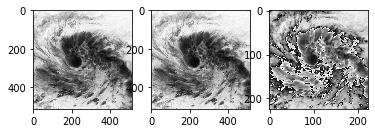

In [37]:
# Transformation we going to use
# Here is just the demo of transformation, the real transformation will defined right before main training loop for easier editing
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(1,3)

transform = transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5])
                    ])

# img = getImageFromNPY(LABELS.loc[i])
with h5py.File(f"{dataset_dir}/compressed_images.hdf5", 'r') as h5:
    getImageFromH5(h5, LABELS.iloc[i])
ax[0].imshow(img, cmap='gray')
# Pretrained CNN network usually need input to have 3 channels, here we stack our array 3 times to pretend we have it
stacked_img = Image.fromarray(np.stack((img,)*3, axis=-1))
ax[1].imshow(stacked_img, cmap='gray')
transformed_img = transform(stacked_img)
ax[2].imshow(transforms.ToPILImage()(transformed_img), cmap='gray')
print("Raw -> Stacked -> Transformed")
plt.show()

## Models

### Building and Training a Model - Take 1: Pre-trained Net

After the preprocessing is complete, a model is developed as baseline.

Firstly we try to use a pre-trained CNN "densenet161" and see how it performs with our data.

For loss function we chose cross entropy loss and optimizer is Adam.

In [ ]:
""" Pre-trained CNN Model """
import torchvision.models as models
class PretrainNet(nn.Module):
    def __init__(self):
        super(PretrainNet, self).__init__()
        # Define layers
        # Input shape: (Batch size, 1, 512, 512)
        # Convolution layer(s)
        self.conv = self.densenet()
        # FC layer(s)
        self.fc = nn.Sequential(
            # 1000 is the default output size in densenet
            nn.Linear(1000, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, 6)
        )

    def densenet(self):
        model = models.densenet161(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        return model

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

Another pre-trained model "EfficientNet" is also tested.

In [38]:
# We also want to test another state of art cnn model, EfficientNet
from efficientnet_pytorch import EfficientNet

class EffNet(nn.Module):
    def __init__(self):
        super(EffNet, self).__init__()

        self.conv = EfficientNet.from_pretrained('efficientnet-b0')

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(62720,1024),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(1024,6),
        )


    def forward(self, x):
        x = self.conv.extract_features(x)
        x = self.fc(x)
        return x

Now with the preparation complete, the following performs the training process.

### Building and Training a Model - Take 2: Custom CNN

This time, we construct our own model from scratch. The structure is as follows:
* Conv2D with 16 filters, kernel size 3 and stride step 1, followed by an average pooling (kernel size 4) layer
* Conv2D with 32 filters, kernel size 3 and stride step 1, followed by a ReLU and an average pooling (kernel size 4) layer
* Conv2D with 64 filters, kernel size 3 and stride step 1, followed by a ReLU and an average pooling (kernel size 2) layer
* Conv2D with 128 filters, kernel size 3 and stride step 1, followed by a ReLU and an average pooling (kernel size 2) layer
* Flattening (2048 neurons) and Linear layer (2048 neurons -> 1024) with ReLU and dropout (0.20 dropout rate)
* Linear (1024 -> 128)
* Linear (128 -> 6) as final layer

The model takes in images of 512x512 instead of 224x224 and is always monochrome. For optimizer and loss function choices, we stick to Adam and Cross Entropy respectively as before.

In [ ]:
""" Custom CNN Model """

class CustomNet1(nn.Module):
    def __init__(self):
        super(CustomNet1, self).__init__()
        # CNN Model layers
        # Input shape: Batch size B, 1 channel, 512, 512

        # conv. layers
        self.conv = nn.Sequential(
            # After 1st conv: (B, 1, 512, 512) -> (B, 16, 512, 512)
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
            # After AvgPool2d: (B, 16, 512, 512) -> (B, 16, 128, 128)
            nn.AvgPool2d(kernel_size=4),
            # After 2nd conv: (B, 16, 128, 128) -> (B, 32, 128, 128)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            # After AvgPool2d: (B, 32, 128, 128) -> (B, 32, 32, 32)
            nn.AvgPool2d(kernel_size=4),
            # After 3rd conv: (B, 32, 32, 32) -> (B, 64, 32, 32)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            # After AvgPool2d: (B, 64, 32, 32) -> (B, 64, 16, 16)
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            # After AvgPool2d: (B, 128, 32, 32) -> (B, 128, 8, 8)
            nn.AvgPool2d(kernel_size=2),
            nn.Flatten()
        )

        # FC layers
        self.fc = nn.Sequential(
            nn.Linear(128*8*8,1024),
            nn.ReLU(True),
            nn.Dropout(0.20),
            nn.Linear(1024, 128),
            nn.Linear(128, 6)
        )

    def forward(self,x):
        x = self.conv(x)
        x = self.fc(x)
        return x

## Train, Vaildate, Test: All Training Procedures

### Training Utility Functions

In [39]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [40]:
class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [41]:
def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 25 epochs"""
    lr = lr * (0.1 ** (epoch // 25))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [42]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [43]:
def accuracy(output, target):
    """Computes the accuracy over the top predictions"""
    with torch.no_grad():
        batch_size = target.size(0)
        
        _, preds = torch.max(output.data, 1)
        correct = (preds == target).sum().item()

        return correct/batch_size

### Main Training Functions

In [44]:
def train(train_loader, model, criterion, optimizer, epoch, freq, gpu):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses, top1,
                             prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)
        # measure accuracy and record loss
        acc1 = accuracy(output, target)
        losses.update(loss.item(), input.size(0))
        top1.update(acc1, input.size(0))

        # compute gradient and do Adam
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % freq == 0:
            progress.print(i)

    return losses.avg

In [45]:
def validate(val_loader, model, criterion, freq, gpu):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, losses, top1, prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda(gpu, non_blocking=True)
            target = target.cuda(gpu, non_blocking=True)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1 = accuracy(output, target)
            losses.update(loss.item(), input.size(0))
            top1.update(acc1, input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % freq == 0:
                progress.print(i)

        print(' * Acc@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg

In [46]:
import time
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

In [47]:
def main_worker(gpu, args):
    global best_acc1
    
    print("Worker {} starts".format(gpu))

    best_acc1 = 0
    ddl = args['ddl']
    lr = args['lr']
    freq = args['freq']

    if ddl:
        dist.init_process_group(
            backend='nccl',
            world_size=args['world_size'],
            rank=gpu
        )

    # define model
    torch.cuda.set_device(gpu)
    model = args['model']
    model.cuda(gpu)

    if ddl:
        args['batch_size'] = int(args['batch_size']/args['gpus'])
        args['worker_size'] = int(
            (args['worker_size'] + args['gpus'] - 1) / args['gpus'])
        model = DDP(model, device_ids=[gpu])

    # define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss().cuda(gpu)

    optimizer = torch.optim.Adam(model.parameters(), lr)

    torch.backends.cudnn.benchmark = True

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        args['train_set']) if ddl else None

    train_loader = DataLoader(args['train_set'],
                              batch_size=args['batch_size'],
                              num_workers=args['worker_size'],
                              pin_memory=args['pin_memory'],
                              drop_last=True,
                              shuffle=(ddl is False),
                              sampler=train_sampler)

    dev_loader = DataLoader(args['dev_set'],
                            batch_size=args['batch_size'],
                            num_workers=args['worker_size'],
                            pin_memory=args['pin_memory'],
                            drop_last=True,
                            shuffle=False)

    losses = []
    accuracies = []

    for epoch in range(0, args['epochs']):
        if ddl:
            train_sampler.set_epoch(epoch)

        adjust_learning_rate(optimizer, epoch, lr)

        # train for one epoch
        loss = train(train_loader, model, criterion, optimizer, epoch, freq, gpu)
        losses.append(loss)
        
        # evaluate on validation set
        acc1 = validate(dev_loader, model, criterion, freq, gpu)
        accuracies.appen(acc1)
        
        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)
        
        if not ddl or (ddl and gpu == 0):
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_acc1': best_acc1,
                'optimizer' : optimizer.state_dict(),
                }, is_best)
    
    # Save stat for analysis usage
    print('Loss over epoch :', losses)
    print('Acc over epoch :', accuracies)
    pd.Dataframe(data={'Loss': losses, 'Accuracy': accuracies}).to_csv(f'{dataset_dir}/train_stats-{gpu}.csv')

In [48]:
train_transform = transforms.Compose([
                        transforms.RandomResizedCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5])
                    ])

dev_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], std=[0.5])
                ])

In [49]:
""" 
Multi GPU will only work in python script(.py), trying to do so in notebook 
will cause inf hang.
""" 
def main():
  # Define arguments here
    args = {
        'model': EffNet(),
        'epochs': 50,
        'lr': 0.01,
        'freq': 100,
        'batch_size': 64,
        'worker_size': 8,
        'pin_memory': True,
        'ddl': False
    }

    dataset = prepare_dataset(LABELS, 0.8, 2012)
    args['train_set'] = TyDataset(dataset['train'], train_transform, channel=3)
    args['dev_set'] = TyDataset(dataset['dev'], dev_transform, channel=3)

    if torch.cuda.device_count() > 1:
        args['gpus'] = torch.cuda.device_count()
        print("Distribute work to {} GPU".format(args['gpus']))
        # Planning to use 1 node + multi-GPU only, so world size = GPU count * 1
        args['world_size'] = args['gpus']
        args['ddl'] = True
        # Set up Master node listening port/addr
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '8889'
        # Spawn processes according to world_size
        mp.spawn(main_worker, nprocs=args['gpus'], args=(args,))
    else:
        main_worker(0, args)

In [ ]:
# Uncomment to run main training loop
main()

In [52]:
""" Evaluating with test set and a saved model """
model = EffNet()
temp = torch.load('model_best.pth.tar')
model.load_state_dict(temp['state_dict'], strict=False)
model.cuda()
test_transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5], std=[0.5])
                ])
dataset = prepare_dataset(LABELS, 0.8, 2012)
test_ds = TyDataset(dataset['test'], test_transform, channel=3)
test_loader = DataLoader(test_ds,
                            batch_size = 128,
                            num_workers= 8,
                            pin_memory= True,
                            drop_last=True,
                            shuffle=True)
acc = validate(val_loader=test_loader, model=model, criterion=nn.CrossEntropyLoss().cuda(0), freq=100, gpu=0)
#print(acc)

Loaded pretrained weights for efficientnet-b0
[Test Size 30738] [Train Size 106341] [Dev Size 26586]
Test: [  0/240]	Time 31.924 (31.924)	Loss 1.8849e+00 (1.8849e+00)	Acc@1   0.05 (  0.05)
Test: [100/240]	Time  1.061 ( 3.084)	Loss 1.8314e+00 (1.8681e+00)	Acc@1   0.16 (  0.11)
Test: [200/240]	Time 15.765 ( 2.825)	Loss 1.8600e+00 (1.8682e+00)	Acc@1   0.15 (  0.11)
 * Acc@1 0.111


## Error Analysis

After obtaining the results above, we decided to start tackling with the issue that there is an outrageously wide gap between train and dev/test accuracies. The first thing we tried was to visualize CNN convolution results.

### Feature map visualization

To implement the code that makes visualization work, the model itself has to be edited a bit, such that `torch.nn.Sequential` is not used to wrap the  convolution layers in one and intermediate layers are accessible.

In [ ]:
""" 
Visualizing conv feature maps with PyTorch
Code modified from https://discuss.pytorch.org/t/visualize-feature-map/29597/2
See also: https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/cnn_layer_visualization.py
"""

# Visualize activations
activation = {}
def get_activation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

# access intermediate layers: remove last 4 layers of conv part
#module = nn.Sequential(*list(test_model.conv.children())[:-4])

test_model.conv.register_forward_hook(get_activation('conv'))
data, _ = next(iter(test_loader)) #obtain random image from dataloader
data = data[0]
data.unsqueeze_(0)
model_cpu = test_model.cpu()
output = model_cpu(data)  # it handles a batch each time...

act = activation['conv'].squeeze() 
print(act.size(0))
fig, axarr = plt.subplots(4,4, figsize=(10,10))
for i in range(4):
  for j in range(4):
    axarr[i][j].imshow(act[i*4+j])

### Training-Dev set

The second thing we tried was to add a training-dev set and observe the model's behaviour. A bit of L2 regulatization is also introduced at this point.

In [ ]:
""" Creating four datasets """
dataset = shuffle(dataset)
train_set_ratio = 0.8
dev_set_ratio = 0.1
test_dev_ratio = 0.1

temp, test_set = train_test_split(dataset, test_size = 1 - train_set_ratio)
test_set, dev_set = train_test_split(test_set, test_size = dev_set_ratio/(1-train_set_ratio))
train_set, train_dev_set = train_test_split(temp, test_size = test_dev_ratio/(train_set_ratio))

print("train set:")
train_set.info()
print("train-dev set:")
train_dev_set.info()
print("dev set:")
dev_set.info()
print("test set:")
test_set.info()

In [ ]:
""" Dataset and DataLoader """
# DataLoader for training set
train_batch_size = batch_size
train_ds = TyDataset(train_set)
train_loader = DataLoader(train_ds, batch_size = train_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(train_ds))

# DataLoader for training-dev set
train_dev_batch_size = batch_size
train_dev_ds = TyDataset(train_dev_set)
train_dev_loader = DataLoader(train_dev_ds, batch_size = train_dev_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training-dev set size (after DataLoader processing):", len(train_dev_ds))

# DataLoader for dev set
dev_batch_size = batch_size
dev_ds = TyDataset(dev_set)
dev_loader = DataLoader(dev_ds, batch_size = dev_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Dev set size (after DataLoader processing):", len(dev_ds))

# DataLoader for test set
test_batch_size = batch_size
test_ds = TyDataset(test_set)
test_loader = DataLoader(test_ds, batch_size = test_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(test_ds))

In [ ]:
""" Device, Criterion and Other Stuff """
# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
if not torch.cuda.is_available():
  print("Suggest you use GPU")

# Get model
test_model = interim_prototype_take2()
test_model = test_model.to(device)
print(test_model)

# Criterion and Optimizer
L2_decay = 0.001  #set up L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(test_model.parameters(), lr=learning_rate, weight_decay=L2_decay)

In [ ]:
""" Modified training loop, with test set evaluation included """
from time import time

all_train_acc, all_td_acc, all_dev_acc = [], [], []
begin_time = time()
for epoch in range(n_epochs):
  print("Running epoch ",epoch,"/",n_epochs,":")
  print("====================")

  log_dict = train_one_epoch(test_model, device=device, criterion=criterion, optimizer=optimizer, dataloader=train_loader)
  train_loss = log_dict['loss'] / len(train_loader)
  train_acc = log_dict['acc']
  all_train_acc.append(train_acc)

  log_dict = eval_one_epoch(test_model, device=device, criterion=criterion, dataloader=train_dev_loader)
  td_loss = log_dict['loss'] / len(train_dev_loader)
  td_acc = log_dict['acc']
  all_td_acc.append(td_acc)

  log_dict = eval_one_epoch(test_model, device=device, criterion=criterion, dataloader=dev_loader)
  dev_loss = log_dict['loss'] / len(dev_loader)
  dev_acc = log_dict['acc']
  all_dev_acc.append(dev_acc)

  finish_time = time()
  print("Time: ", finish_time-begin_time)
  print("---- Training ----")
  print("Loss: ", train_loss)
  print("Acc: ", train_acc)
  print("---- Training-Dev ----")
  print("Loss: ", td_loss)
  print("Acc: ", td_acc)
  print("----Dev----")
  print("Loss: ", dev_loss)
  print("Acc: ", dev_acc)
  print("====================")

In [ ]:
log_dict = eval_one_epoch(test_model, device, criterion, dataloader=test_loader)
test_loss = log_dict['loss']
test_acc = log_dict['acc']
print("Test results:")
print("====================")
print("Loss: ", test_loss)
print("Acc: ", test_acc)
print("Behold!")
print("====================")

In [ ]:
""" Visualization: Accuracies against time """
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
plt.title("Interim Prototype Model: Custom CNN Accuracy")
ax.plot(all_train_acc, label="Training")
ax.plot(all_td_acc, label="Training-Dev")
ax.plot(all_dev_acc, label="Dev")
plt.hlines(test_acc, xmin=0, xmax=n_epochs-1, label="Test", linestyles='dashed')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.show()

---

In [ ]:
""" For CV later """
from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit
from sklearn.model_selection import GridSearchCV, cross_val_score

begin_time = time()
test_net = NeuralNetClassifier(
    # PyTorch model
    module = interim_model_1,
    max_epochs = n_epochs,
    lr = learning_rate,
    device = 'cuda',
    criterion = nn.CrossEntropyLoss,
    optimizer = optim.Adam,
    optimizer__lr = learning_rate,
    batch_size = batch_size,
    # internal train/validation split by skorch
    # use pytorch dataset is ok, auto-wrapped
    # here validated against dev set
    train_split = predefined_split(dev_ds), 
)

# Directly fitting the model
test_net.fit(train_ds)
finish_time = time()

# Test set validate
test_score = test_net.score(test_ds)
print("Raw test accuracy: ", test_score)
# 5-fold CV scores
cv_scores = cross_val_score(test_net, train_ds, cv=5, scoring='accuracy')
print("5-Fold CV scores: ", cv_scores)
print("Mean: ", cv_scores.mean())

## Demo of current model

Lets give a typhoon picture to our current model to see how the models perform!


In [ ]:
from PIL import Image
import requests
from io import BytesIO
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


response = requests.get('http://agora.ex.nii.ac.jp/digital-typhoon/wsp/by-name/201822/bd/512x512/HMW818032312.201822.jpg')
img = Image.open(BytesIO(response.content))
imgplot = plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
    ]
)
t = transform(img).unsqueeze(0).cuda()
with torch.no_grad():
  outputs = interim_model_1(t)
  _, predicted = torch.max(outputs.data, 1)
  print(predicted)
  

In [ ]:
transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),  
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

t = transform(img.convert('RGB')).unsqueeze(0).cuda()

with torch.no_grad():
  outputs = interim_model(t)
  _, predicted = torch.max(outputs.data, 1)
  print(predicted)